In [1]:
import numpy as np
import os
import torch
import torch.nn.functional as F
from typing import List, Optional, Tuple, Union
from transformers import PreTrainedModel, AutoModelForSequenceClassification, T5ForConditionalGeneration
from transformers import AutoTokenizer
import datasets

import math
from matplotlib import pyplot as plt


from typing import List, Optional, Tuple, Union
from transformers import BertForSequenceClassification
import transformers
from transformers.modeling_outputs import SequenceClassifierOutput

### Finetune

In [2]:
import sys
sys.path.append('..')
from transformers import AutoModelForSequenceClassification
from modeling_rmt import RMTEncoderForSequenceClassification
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
# from modeling_rmt import RMTEncoderForSequenceClassification
# from modeling_rmt_enc_dec import RMTEncoderDecoderForConditionalGeneration

In [3]:
num_segments = 6
num_mem_tokens = 10
# device = torch.device(3)
device = 'cpu'

In [4]:
model_name = 'bert-base-cased'

tokenizer = AutoTokenizer.from_pretrained(model_name)

rmt_config = {'num_mem_tokens': num_mem_tokens, 
                'max_n_segments': num_segments,
                'tokenizer': tokenizer,
               #  'memory_layers': 'all', 
               #  'share_memory_layers': True,
               #  'reconstruction_loss_coef': 0.1,
                'segment_ordering': 'regular',
                'input_size': 512, 
                'bptt_depth': -1, 
                'sum_loss': False,
             }

# base_model1 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)
# rmt1 = RMTEncoderForSequenceClassification(base_model1, **rmt_config)

# base_model2 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)
# rmt2 = RMTEncoderForSequenceClassification(base_model2, **rmt_config)

base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6).cpu()
rmt = RMTEncoderForSequenceClassification(base_model, **rmt_config).cpu()

# rmt = RMTEncoderMemoryLayers(base_model, **rmt_config)
# rmt = RMTEncoderMLMMemLoss(base_model, **rmt_config)
# rmt = RMTEncoderHorizontalMemory(base_model, **rmt_config)
# rmt.to(device)

/cephfs/home/bulatov/bulatov/hvdenv/lib/python3.8/site-packages/cryptography/hazmat/backends/openssl/x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from 

In [5]:
# cpt = torch.load('../../runs/curriculum_task/babilong_random_v2/bert-base-cased/lr1e-05_linear_adamw_wd1e-03_998-512-{3}seg_mem10_bs32_iters3000_regular_from_cpt_1-2/run_1/model_best.pth', map_location=device)
cpt = torch.load('../../runs/curriculum_task/babilong_reasoning/bert-base-cased/lr1e-05_linear_adamw_wd1e-03_2994-512-{6}seg_mem10_bs32_iters3000_regular_from_cpt_5-6/run_1/model_best.pth', map_location=device)

In [6]:
rmt.load_state_dict(cpt['model_state_dict'])
# rmt1.load_state_dict(cpt1['model_state_dict'])
# rmt2.load_state_dict(cpt2['model_state_dict'])

<All keys matched successfully>

In [7]:
# out = rmt(sample_input_ids, **kwargs, output_hidden_states=False, output_attentions=False)
# out.keys()

### load dataset 

In [9]:
class Holder:
    def __init__(self):
        pass

In [10]:
input_seq_len = 499 * 6
target_seq_len = 512
batch_size = 1

args = Holder
args.num_mem_tokens = 10
args.max_n_segments = 6
args.input_size = 512
args.target_seq_len = target_seq_len
args.input_seq_len = input_seq_len
args.input_prefix = ''
device = 'cpu'

In [15]:
import pandas as pd
from datasets import load_dataset
class MemoryReasoningDataset(Dataset):
    def __init__(self, split='train', dataset='quality', num_samples=None):
        self.dataset = load_dataset('tau/scrolls', dataset)[split]
        self.fact_dataset = pd.read_csv('/home/bulatov/bulatov/datasets/babi/_processed/two_facts_reasoning.csv')
        self.num_samples = num_samples

    def __getitem__(self, ind):
        
        noise_ind = np.random.randint(len(self.dataset))
        fact_ind = np.random.randint(len(self.fact_dataset))
        sample = self.dataset[noise_ind]
        sample.update(dict(self.fact_dataset.iloc[fact_ind]))
        return sample
    
    def __len__(self):
        return self.num_samples

In [16]:
train_dataset = MemoryReasoningDataset(split='train', dataset='quality', num_samples=100_000)
valid_dataset = MemoryReasoningDataset(split='validation', dataset='quality', num_samples=2_000)

/cephfs/home/bulatov/bulatov/hvdenv/lib/python3.8/site-packages/cryptography/hazmat/backends/openssl/x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
Found cached dataset scrolls (/home/bulatov/.cache/huggingface/datasets/tau___scrolls/quality/1.0.0/672021d5d8e1edff998a6ea7a5bff35fdfd0ae243e7cf6a8c88a57a04afb46ac)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset scrolls (/home/bulatov/.cache/huggingface/datasets/tau___scrolls/quality/1.0.0/672021d5d8e1edff998a6ea7a5bff35fdfd0ae243e7cf6a8c88a57a04afb46ac)


  0%|          | 0/3 [00:00<?, ?it/s]

### enc-dec

In [20]:
# # raise NotImplementedError
# global_attention_first_token = False  # should be True for LED
# encode_plus_kwargs = {'truncation': True, 'padding': 'longest', 'pad_to_multiple_of': 1}
# # generate_kwargs = {'max_length': args.target_seq_len, 'min_length': args.target_seq_len}
# generate_kwargs = {}

# def collate_fn(batch):
#     # cut too long strings because they may slow down tokenization
#     inputs = [b['fact'] + b['input'][:args.input_seq_len * 10] for b in batch]
#     questions = [b['question'] for b in batch]
#     labels = [b['answer'][:args.target_seq_len * 10] for b in batch]
#     if args.input_prefix:
#         inputs = [args.input_prefix + inp for inp in inputs]

#     max_length = min(args.max_n_segments * input_seg_size, args.input_seq_len)
#     features = tokenizer.batch_encode_plus(list(inputs), return_tensors='pt', **encode_plus_kwargs, max_length=max_length)
#     questions = tokenizer.batch_encode_plus(list(questions), return_tensors='pt', **encode_plus_kwargs)['input_ids']

#     with tokenizer.as_target_tokenizer():
#         labels = tokenizer.batch_encode_plus(list(labels), max_length=args.target_seq_len, return_tensors='pt',
#                                                 **encode_plus_kwargs).input_ids
#     labels[labels == tokenizer.pad_token_id] = -100
#     features['labels'] = labels
#     features['id'] = [b['id'] for b in batch]
#     features['target_text'] = [b['answer'] for b in batch]
#     if 'global_attention_mask' in features:
#         raise RuntimeError('What global attention mask for Longformer and LongformerEncoder-Decoder should be?')
#     return features


### enc

In [20]:
answers = train_dataset.fact_dataset.answer.unique()
labels_map = dict(zip(answers, range(len(answers))))
num_labels = len(labels_map)
if args.num_mem_tokens is None:
    input_seg_size = args.input_size
else:
    input_seg_size = args.input_size - args.num_mem_tokens - tokenizer.num_special_tokens_to_add()
    if 'sep_token' in tokenizer.special_tokens_map:
        input_seg_size -= 1

In [21]:
fact1_segment = 0
fact2_segment = 3
random_position = False

In [25]:
encode_plus_kwargs = {
                            #   'max_length': args.input_seq_len,
                              'truncation': True,
                              'padding': 'longest',
                              'pad_to_multiple_of': 1}

In [22]:
def collate_fn(batch, input_seg_size=input_seg_size, fact1_segment=fact1_segment, fact2_segment=fact2_segment, random_position=random_position):
    facts1 = [b['fact1'] for b in batch]
    facts2 = [b['fact2'] for b in batch]
    inputs = [' '.join([b['input']]) * int(np.ceil(args.input_seq_len * 10 / len(b['input']))) for b in batch]
    questions = [b['question'] for b in batch]
    labels = [b['answer'][:args.target_seq_len * 10] for b in batch]
    if args.input_prefix:
        inputs = [args.input_prefix + inp for inp in inputs]

    total_input_size = args.max_n_segments * input_seg_size
    features = tokenizer.batch_encode_plus(list(inputs), return_tensors='pt', **encode_plus_kwargs, max_length=total_input_size)
    questions = tokenizer.batch_encode_plus(list(questions), return_tensors='pt', **encode_plus_kwargs)['input_ids']

    if random_position:
        fact1_start_positions = np.random.randint(0, args.max_n_segments, len(batch)) * input_seg_size + 1
        fact2_start_positions = np.random.randint(0, args.max_n_segments, len(batch)) * input_seg_size + 1
    else:
        fact1_start_positions = np.ones(len(batch), dtype=int) * fact1_segment * input_seg_size + 1
        fact2_start_positions = np.ones(len(batch), dtype=int) * fact2_segment * input_seg_size + 1

    for i, (position1, position2) in enumerate(zip(fact1_start_positions, fact2_start_positions)):
        fact1 = tokenizer.encode(facts1[i], return_tensors='pt', add_special_tokens=False)[0]
        fact2 = tokenizer.encode(facts2[i], return_tensors='pt', add_special_tokens=False)[0]
        if position1 == position2:
            position2 += len(fact1)
        features['input_ids'][i, position1:position1 + len(fact1)] = fact1
        features['input_ids'][i, position2:position2 + len(fact2)] = fact2

    q_len = questions.shape[1] - 1
    max_length = min(args.max_n_segments * input_seg_size, args.input_seq_len)
    features['input_ids'] = torch.cat([features['input_ids'][:, :max_length - q_len], questions[:, 1:]], dim=1)
    
    labels = np.array([labels_map[t] for t in labels])
    features['labels'] = torch.from_numpy(labels)
    return features

In [26]:
# train_sampler = DistributedSampler(train_dataset, rank=hvd.rank(), num_replicas=hvd.size(), shuffle=True,
#                                        drop_last=False, seed=args.seed)
# per_worker_batch_size = args.batch_size * args.gradient_accumulation_steps
# global_batch_size = per_worker_batch_size * hvd.size()
kwargs = {'pin_memory': True, 'num_workers': 1}
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,# sampler=train_sampler,
                                collate_fn=collate_fn, **kwargs)
# # get validation dataset
# valid_dataloader = None
# if hvd.rank() == 0:
#     logger.info(f'preparing validation data from babilong')
# # if args.task_name in tasks_with_duplicates:
# #     valid_dataset = drop_duplicates_in_input(valid_dataset)
# valid_sampler = DistributedSampler(valid_dataset, rank=hvd.rank(), num_replicas=hvd.size(), shuffle=False)
# valid_dataloader = DataLoader(valid_dataset, batch_size=per_worker_batch_size, sampler=valid_sampler,
#                                 collate_fn=collate_fn, **kwargs)

In [27]:
gen = iter(train_dataloader)
batch = next(gen)


In [33]:
tokenizer.decode(input_ids[0][:30])

"[CLS] The garden is west of the hallway.? ( A ) There isn't a lot of water there, and he needs to be able to"

In [35]:
tokenizer.decode(input_ids[0][3 * 499 + 1:])

'The kitchen is east of the hallway. Then Johnson rubbed his thumb on his index finger and wetted his lips expectantly. Harvey bravely counted off the bills. He asked : " But what are we to do about replenishing our battery fluid? Ten buckos a liter would be preposterous. We simply can\'t afford it. " Johnson\'s response almost floored them. " Who said anything about charging you for battery water? You can have all you want for nothing. It\'s just the purified stuff that comes so high. " After giving them directions that would take them to the free - water pool, the ponderous factotum of Planetoid 42 shook hands and headed back to the saloon. His six - armed assistant followed him inside. " Now do you see, my hot - tempered colleague? " said Harvey as he and Joe picked up buckets that hung on the tank. " Johnson, as I saw instantly, is the victim of a difficult environment, and must charge accordingly. " " Just the same, " Joe griped, " paying for water isn\'t something you can get use

In [36]:
tokenizer.decode(input_ids[0][-20:])

'I\'m fine now! " he cried, and sprang What is the hallway east of? [SEP]'

In [29]:
input_ids = batch.pop('input_ids')
out = rmt(input_ids, **batch, output_attentions = True)
# out1 = rmt1(input_ids, **batch, output_attentions = True)
# out2 = rmt2(input_ids, **batch, output_attentions = True)

In [31]:
out.loss

tensor(0.0127, grad_fn=<NllLossBackward>)

In [37]:
[(key, out[key]) for key in out if 'loss' in key]

[('loss', tensor(0.0127, grad_fn=<NllLossBackward>)),
 ('loss_0', tensor(0.0028, grad_fn=<NllLossBackward>)),
 ('loss_1', tensor(0.0226, grad_fn=<NllLossBackward>)),
 ('loss_2', tensor(0.0694, grad_fn=<NllLossBackward>)),
 ('loss_3', tensor(2.8225, grad_fn=<NllLossBackward>)),
 ('loss_4', tensor(4.8090, grad_fn=<NllLossBackward>)),
 ('loss_5', tensor(0.0127, grad_fn=<NllLossBackward>))]

In [50]:
tokenizer.decode(input_ids[0][499:])

'd Mary went back to the hallway. over. It was better to retire on a limited crediting, on a confoundedly limited crediting, than to take the two or three more trips in hopes of attaining a higher standard. He\'d had plenty of time to figure it out, there alone in space on the Moon run, there on the Venus or Mars runs. There on the long, long haul to the Jupiter satellites, fearfully checking the symptoms of space cafard, the madness compounded of claustrophobia, monotony, boredom and free fall. Plenty of time. Time to decide that a one room mini - auto - apartment, complete with an autochair and built - in autobar, and with one wall a teevee screen, was all he needed to find contentment for a mighty long time. Possibly somebody like Doc Girard - Perregaux might be horrified at the idea of living in a mini - auto - apartment... not realizing that to a pilot it was roomy beyond belief compared to the conning tower of a space craft. No. Even as Si listened to their speeches, accepted the

### plot attentions


In [38]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

def plot_attention_weights(attentions, tokens, y_tokens=None, p_attentions=None, filename='att.png', save=False, size=None):
    # attentions n_layers x n_heads x len x len
    attention = attentions.detach()
    if size is not None:
        sz = size
    else:
        sz = max(*attention.shape) // 3
    fig = plt.figure(figsize=(sz, sz))
    if y_tokens is None:
        y_tokens = tokens
        fig = plt.figure(figsize=(sz, 3*sz))
    y_tokens = y_tokens[:attention.shape[1]]
    tokens = tokens[:attention.shape[2]]    

    
    # if p_attentions:
    #     p_attention = p_attentions[layer]

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(6, 2, head+1)

        # plot the attention weights
        if p_attentions:
            att = np.concatenate([np.expand_dims(p_attention[head], axis=0), attention[head]], axis=0)
            ax.matshow(att[:len(y_tokens)+1,:len(tokens)], cmap='Reds')
        else:
            ax.matshow(attention[head][:len(y_tokens),:len(tokens)], cmap='Reds')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(tokens)))
        if p_attentions:
            ax.set_yticks(range(len(y_tokens) + 1))
            ax.set_yticklabels(['[P]'] + y_tokens, fontdict)
        else:
            ax.set_yticks(range(len(y_tokens)))
            # print('y_tokens', len(y_tokens), y_tokens)
            ax.set_yticklabels(y_tokens)#, fontdict)

        ax.set_xticklabels(tokens,fontdict=fontdict, rotation=90)

        ax.set_xlabel('Head {}'.format(head+1), fontdict)

    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show()

In [39]:
segmented = rmt.pad_and_segment(input_ids)

### seg 0: Write to memory

<Figure size 720x720 with 0 Axes>

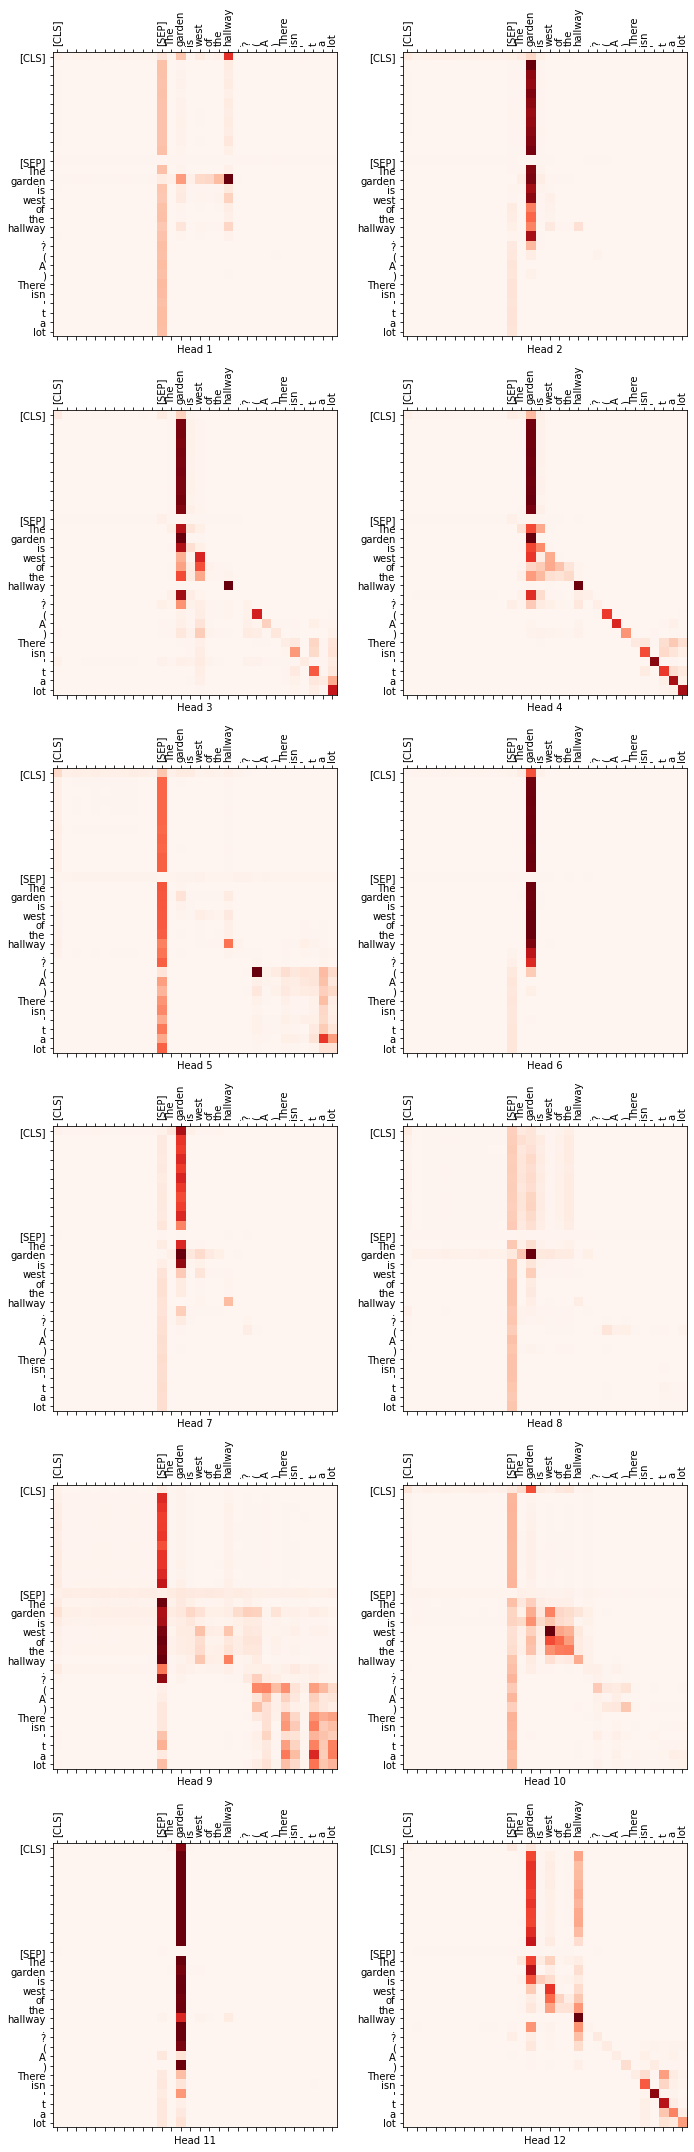

In [40]:
layer = -1
segment = 0
bn = 0

min_x, max_x = 0, 30
min_y, max_y = 0, 30


tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out[f'attentions_{segment}']

fn = f'img/rmt5_attn_seg{segment}_l{layer}.png'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)

### seg3

In [41]:
len(attentions), attentions[0].shape

(12, torch.Size([1, 12, 512, 512]))

In [42]:
head = 0
attentions[layer][bn][head]

tensor([[9.5618e-03, 2.4650e-03, 6.0229e-03,  ..., 3.5291e-02, 0.0000e+00,
         0.0000e+00],
        [1.0437e-03, 2.0909e-05, 5.4220e-05,  ..., 8.2446e-02, 0.0000e+00,
         0.0000e+00],
        [1.5069e-03, 3.6439e-05, 1.0060e-04,  ..., 8.1685e-02, 0.0000e+00,
         0.0000e+00],
        ...,
        [2.8820e-03, 1.7342e-03, 1.8779e-03,  ..., 3.9721e-03, 0.0000e+00,
         0.0000e+00],
        [2.4182e-03, 5.5880e-05, 9.0071e-05,  ..., 8.2442e-02, 0.0000e+00,
         0.0000e+00],
        [2.5509e-03, 1.0276e-04, 1.5790e-04,  ..., 8.1631e-02, 0.0000e+00,
         0.0000e+00]], grad_fn=<SelectBackward>)

<Figure size 720x720 with 0 Axes>

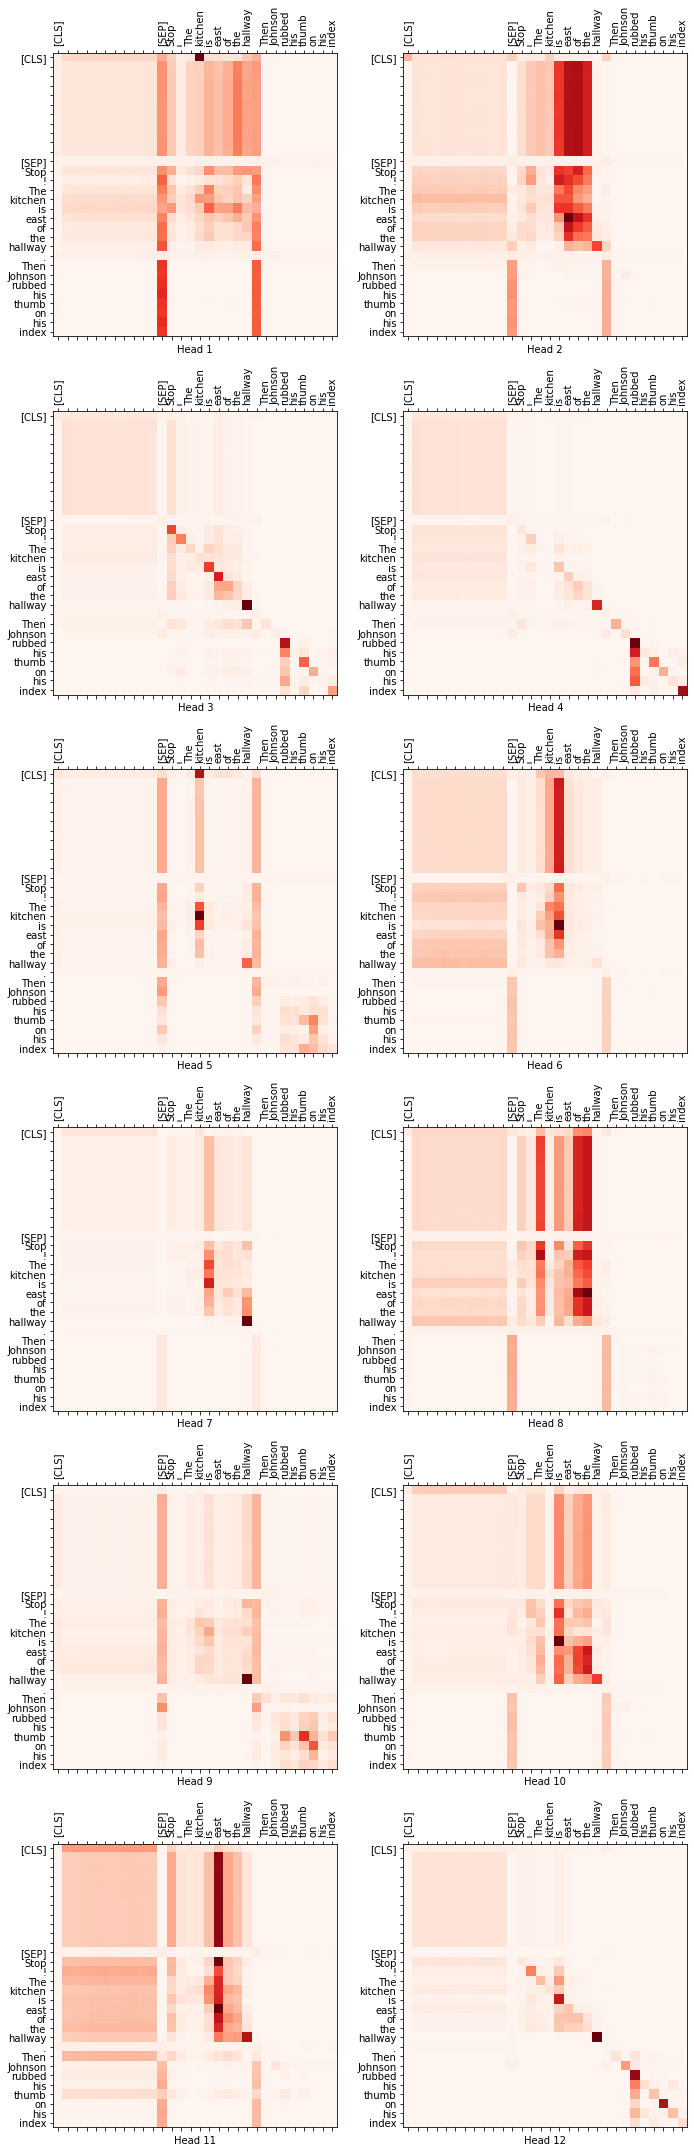

In [43]:
layer = -1
segment = 3
bn = 0

min_x, max_x = 0, 30
min_y, max_y = 0, 30


tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out[f'attentions_{segment}']

fn = f'img/rmt5_attn_seg{segment}_l{layer}.png'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)

### last seg

<Figure size 720x720 with 0 Axes>

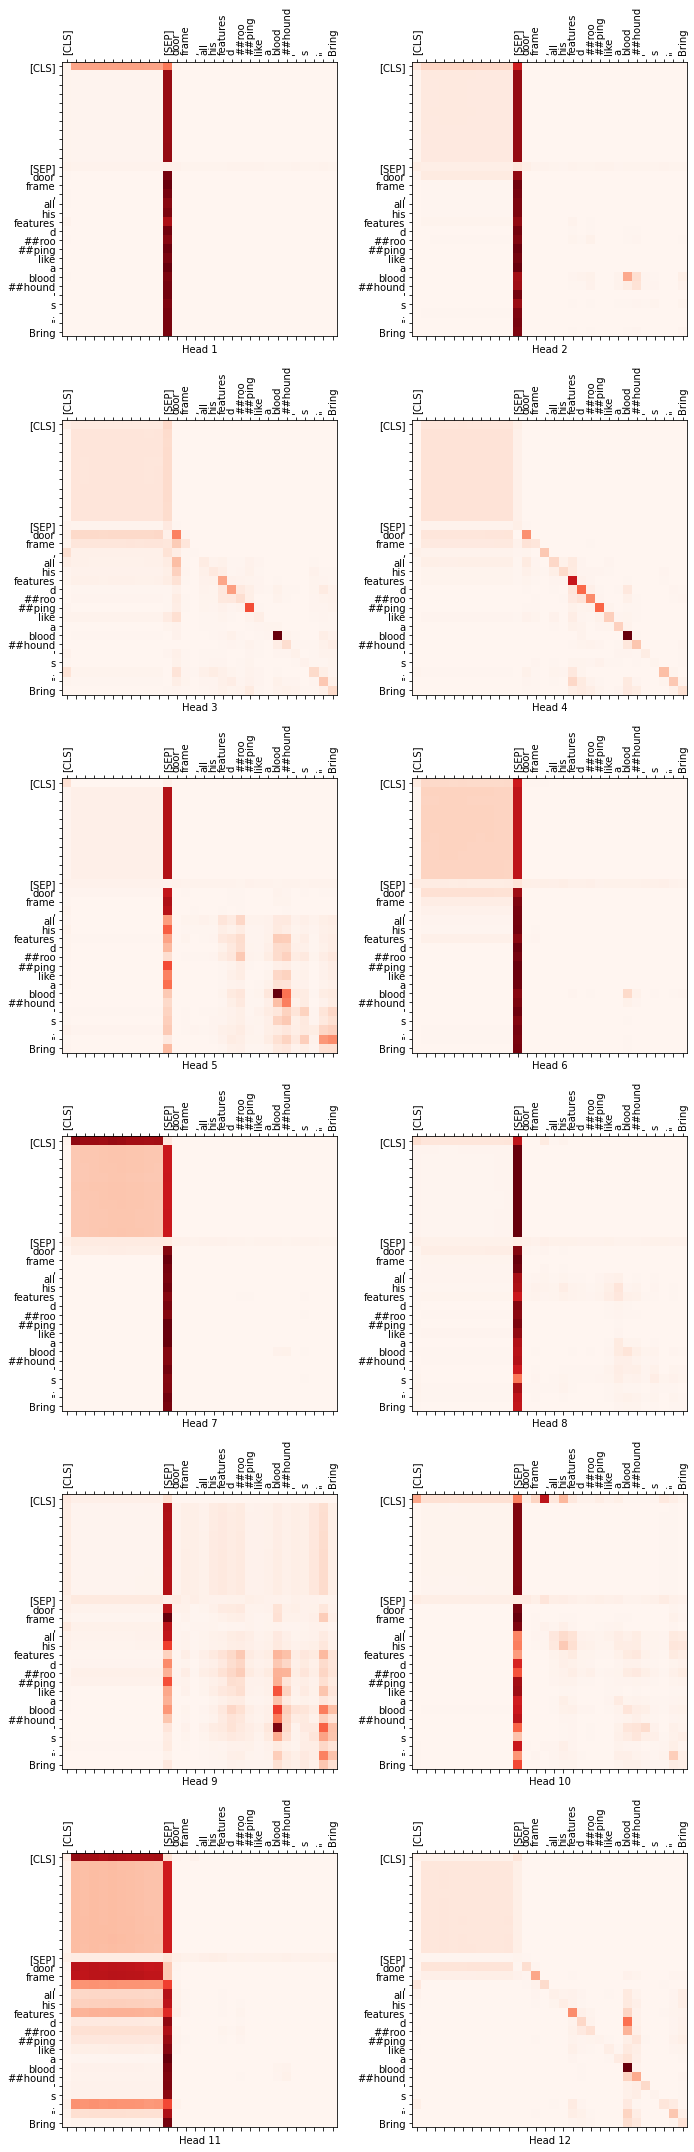

Traceback (most recent call last):
  File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/cephfs/home/bulatov/bulatov/hvdenv/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/cephfs/home/bulatov/bulatov/hvdenv/lib/python3.8/site-packages/traitlets/config/application.py", line 976, in launch_instance
    app.start()
  File "/cephfs/home/bulatov/bulatov/hvdenv/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/cephfs/home/bulatov/bulatov/hvdenv/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "/usr/lib/python3.8/asyncio/base_events.py", line 1823, in

: 

In [46]:
layer = -1
segment = 5
bn = 0

min_x, max_x = 0, 30
min_y, max_y = 0, 30


tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out[f'attentions_{segment}']

fn = f'img/rmt5_attn_seg{segment}_l{layer}.png'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)